<a href="https://colab.research.google.com/github/wongchunghang/Colab_OpenAI_Gym_Stock_Trading/blob/master/OpenAI_Gym_Trading_Env_V0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TradingEnv-v0

### Evergreening of Trading Game in Open AI Gym Simulation Environment Original by Tito Ingargiola
This is an colab notebook implementation of Trading Game in Open AI Gym simulation environment. Original implementation is created by December 2016 by Tito Ingargiola. Tito has done a great work and his github link is https://github.com/hackthemarket/gym-trading. The original notebook is created in 2016 and after some packages update(e.g. the gym module), the notebook in the github will throw errors. So I fixed some of the issues and also made the corresponding changes required so that it can run smoothly in colab. 

I hope this is a starting point for those RL hobbist for whom working on bringing RL to Algo Trading. Also, I chose the open AI gym because it provides stardardized simulation environment to particular problem domain. This can make the least effort to try different RL algorithms provided by other RL researchers by just simply plug and play the agents. It somehow links the concept of transfer learning https://www.analyticsindiamag.com/transfer-learning-deep-learning-significance/ so that the algorithm used to solve the cart-pole problem may apply to trading world as well.


### Open AI 'Gym' for reinforcement-learning based trading algorithms

This gym implements a very simple trading environment for reinforcement learning.

The gym provides daily observations based on real market data pulled from Quandl on, by default, the SPY etf.  An episode is defined as 252 contiguous days sampled from the overall dataset.  Each day is one 'step' within the gym and for each step, the algo has a choice:

 - SHORT (0)
 - FLAT (1)
 - LONG  (2)
 
If you trade, you will be charged, by default, 10 BPS of the size of your trade.  Thus, going from short to long costs twice as much as going from short to/from flat.  Not trading also has a default cost of 1 BPS per step.  Nobody said it would be easy!
 
At the beginning of your episode, you are allocated 1 unit of cash.  This is your starting Net Asset Value (NAV). 

### Beating the trading game 

For our purposes, we'll say that beating a buy & hold strategy, on average, over one hundred episodes will notch a win to the proud ai player.  We'll illustrate exactly what that means below.

### Let's look at some code using the environment


###  imports

In [0]:
!pip install quandl


In [0]:
import gym
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)



In [0]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)

import quandl
import numpy as np
from numpy import random
import pandas as pd
import logging
import pdb

import tempfile

log = logging.getLogger(__name__)
log.info('%s logger started.',__name__)

QUANDL_TARGET_NAME = "HKEX/00005"

def _sharpe(Returns, freq=252) :
  """Given a set of returns, calculates naive (rfr=0) sharpe """
  return (np.sqrt(freq) * np.mean(Returns))/np.std(Returns)

def _prices2returns(prices):
  px = pd.DataFrame(prices)
  nl = px.shift().fillna(0)
  R = ((px - nl)/nl).fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
  R = np.append( R[0].values, 0)
  return R

class QuandlEnvSrc(object):
  ''' 
  Quandl-based implementation of a TradingEnv's data source.
  
  Pulls data from Quandl, preps for use by TradingEnv and then 
  acts as data provider for each new episode.
  '''

  MinPercentileDays = 100 
  QuandlAuthToken = ""  # not necessary, but can be used if desired
  #Name = "TSE/9994" # https://www.quandl.com/search (use 'Free' filter)
  Name = QUANDL_TARGET_NAME # https://www.quandl.com/search (use 'Free' filter)

  def __init__(self, days=252, name=Name, auth=QuandlAuthToken, scale=True ):
    self.name = name
    self.auth = auth
    self.days = days+1
    log.info('getting data for %s from quandl...',QuandlEnvSrc.Name)
    df = quandl.get(self.name) if self.auth=='' else quandl.get(self.name, authtoken=self.auth)
    log.info('got data for %s from quandl...',QuandlEnvSrc.Name)
    
    df = df[ ~np.isnan(df['Share Volume (000)'])][['Nominal Price','Share Volume (000)']]
    # we calculate returns and percentiles, then kill nans
    df = df[['Nominal Price','Share Volume (000)']]   
    df['Share Volume (000)'].replace(0,1,inplace=True) # days shouldn't have zero volume..
    df['Return'] = (df['Nominal Price']-df['Nominal Price'].shift())/df['Nominal Price'].shift()
    pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
    df['ClosePctl'] = df['Nominal Price'].expanding(self.MinPercentileDays).apply(pctrank)
    df['VolumePctl'] = df['Share Volume (000)'].expanding(self.MinPercentileDays).apply(pctrank)
    df.dropna(axis=0,inplace=True)
    R = df.Return
    if scale:
      mean_values = df.mean(axis=0)
      std_values = df.std(axis=0)
      df = (df - np.array(mean_values))/ np.array(std_values)
    df['Return'] = R # we don't want our returns scaled
    self.min_values = df.min(axis=0)
    self.max_values = df.max(axis=0)
    self.data = df
    self.step = 0
    
  def reset(self):
    # we want contiguous data
    self.idx = np.random.randint( low = 0, high=len(self.data.index)-self.days )
    self.step = 0

  def _step(self):    
    obs = self.data.iloc[self.idx].as_matrix()
    self.idx += 1
    self.step += 1
    done = self.step >= self.days
    return obs,done

class TradingSim(object) :
  """ Implements core trading simulator for single-instrument univ """

  def __init__(self, steps, trading_cost_bps = 1e-3, time_cost_bps = 1e-4):
    # invariant for object life
    self.trading_cost_bps = trading_cost_bps
    self.time_cost_bps    = time_cost_bps
    self.steps            = steps
    # change every step
    self.step             = 0
    self.actions          = np.zeros(self.steps)
    self.navs             = np.ones(self.steps)
    self.mkt_nav         = np.ones(self.steps)
    self.strat_retrns     = np.ones(self.steps)
    self.posns            = np.zeros(self.steps)
    self.costs            = np.zeros(self.steps)
    self.trades           = np.zeros(self.steps)
    self.mkt_retrns       = np.zeros(self.steps)
    
  def reset(self):
    self.step = 0
    self.actions.fill(0)
    self.navs.fill(1)
    self.mkt_nav.fill(1)
    self.strat_retrns.fill(0)
    self.posns.fill(0)
    self.costs.fill(0)
    self.trades.fill(0)
    self.mkt_retrns.fill(0)
    
  def _step(self, action, retrn ):
    """ Given an action and return for prior period, calculates costs, navs,
        etc and returns the reward and a  summary of the day's activity. """

    bod_posn = 0.0 if self.step == 0 else self.posns[self.step-1]
    bod_nav  = 1.0 if self.step == 0 else self.navs[self.step-1]
    mkt_nav  = 1.0 if self.step == 0 else self.mkt_nav[self.step-1]

    self.mkt_retrns[self.step] = retrn
    self.actions[self.step] = action
    
    self.posns[self.step] = action - 1     
    self.trades[self.step] = self.posns[self.step] - bod_posn
    
    trade_costs_pct = abs(self.trades[self.step]) * self.trading_cost_bps 
    self.costs[self.step] = trade_costs_pct +  self.time_cost_bps
    reward = ( (bod_posn * retrn) - self.costs[self.step] )
    self.strat_retrns[self.step] = reward

    if self.step != 0 :
      self.navs[self.step] =  bod_nav * (1 + self.strat_retrns[self.step-1])
      self.mkt_nav[self.step] =  mkt_nav * (1 + self.mkt_retrns[self.step-1])
    
    info = { 'reward': reward, 'nav':self.navs[self.step], 'costs':self.costs[self.step] }

    self.step += 1      
    return reward, info

  def to_df(self):
    """returns internal state in new dataframe """
    cols = ['action', 'bod_nav', 'mkt_nav','mkt_return','sim_return',
            'position','costs', 'trade' ]
    rets = _prices2returns(self.navs)
    #pdb.set_trace()
    df = pd.DataFrame( {'action':     self.actions, # today's action (from agent)
                          'bod_nav':    self.navs,    # BOD Net Asset Value (NAV)
                          'mkt_nav':  self.mkt_nav, 
                          'mkt_return': self.mkt_retrns,
                          'sim_return': self.strat_retrns,
                          'position':   self.posns,   # EOD position
                          'costs':  self.costs,   # eod costs
                          'trade':  self.trades },# eod trade
                         columns=cols)
    return df

class TradingEnv(gym.Env):
  """This gym implements a simple trading environment for reinforcement learning.

  The gym provides daily observations based on real market data pulled
  from Quandl on, by default, the SPY etf. An episode is defined as 252
  contiguous days sampled from the overall dataset. Each day is one
  'step' within the gym and for each step, the algo has a choice:

  SHORT (0)
  FLAT (1)
  LONG (2)

  If you trade, you will be charged, by default, 10 BPS of the size of
  your trade. Thus, going from short to long costs twice as much as
  going from short to/from flat. Not trading also has a default cost of
  1 BPS per step. Nobody said it would be easy!

  At the beginning of your episode, you are allocated 1 unit of
  cash. This is your starting Net Asset Value (NAV). If your NAV drops
  to 0, your episode is over and you lose. If your NAV hits 2.0, then
  you win.

  The trading env will track a buy-and-hold strategy which will act as
  the benchmark for the game.

  """
  metadata = {'render.modes': ['human']}

  def __init__(self):
    self.days = 252
    self.src = QuandlEnvSrc(days=self.days)
    self.sim = TradingSim(steps=self.days, trading_cost_bps=1e-3,
                          time_cost_bps=1e-4)
    self.action_space = spaces.Discrete( 3 )
    self.observation_space= spaces.Box( self.src.min_values,
                                        self.src.max_values)
    self._reset()

  def _configure(self, display=None):
    self.display = display

  def _seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def step(self, action):
    assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
    observation, done = self.src._step()
    # Close    Volume     Return  ClosePctl  VolumePctl
    yret = observation[2]

    reward, info = self.sim._step( action, yret )
      
    #info = { 'pnl': daypnl, 'nav':self.nav, 'costs':costs }

    return observation, reward, done, info
  
  def _reset(self):
    self.src.reset()
    self.sim.reset()
    return self.src._step()[0]

  def reset(self):
    return self._reset()
    
  def _render(self, mode='human', close=False):
    #... TODO
    pass

  # some convenience functions:
  
  def run_strat(self,  strategy, return_df=True):
    """run provided strategy, returns dataframe with all steps"""
    observation = self._reset()
    done = False
    while not done:
      action = strategy( observation, self ) # call strategy
      observation, reward, done, info = self.step(action)

    return self.sim.to_df() if return_df else None
      
  def run_strats( self, strategy, episodes=1, write_log=True, return_df=True):
    """ run provided strategy the specified # of times, possibly
        writing a log and possibly returning a dataframe summarizing activity.
    
        Note that writing the log is expensive and returning the df is moreso.  
        For training purposes, you might not want to set both.
    """
    logfile = None
    if write_log:
      logfile = tempfile.NamedTemporaryFile(delete=False)
      log.info('writing log to %s',logfile.name)
      need_df = write_log or return_df

    alldf = None
        
    for i in range(episodes):
      df = self.run_strat(strategy, return_df=need_df)
      if write_log:
        df.to_csv(logfile, mode='a')
        if return_df:
          alldf = df if alldf is None else pd.concat([alldf,df], axis=0)
            
    return alldf


INFO:__main__:__main__ logger started.


### create the environment

This may take a moment as we are pulling historical data from quandl.

In [0]:
#env = gym.make('trading-v0')
env = TradingEnv()
env.timestep_limit=1000


INFO:__main__:getting data for HKEX/00005 from quandl...
INFO:__main__:got data for HKEX/00005 from quandl...


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


### the trading model

Each time step is a day.  Each episode is 252 trading days - a year.  Each day, we can choose to be short (0), flat (1) or long (2) the single instrument in our trading universe.

Let's run through a day and stay flat.

Annualized return:  -0.024788838058855234


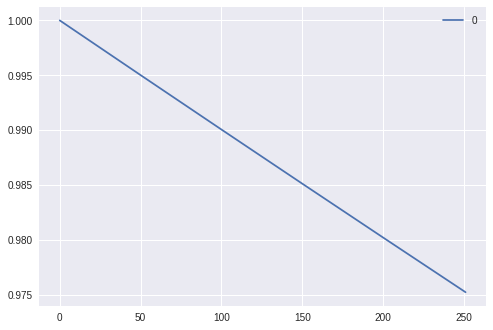

In [0]:
observation = env.reset()
done = False
navs = []
while not done:
    action = 1 # stay flat
    observation, reward, done, info = env.step(action)
    navs.append(info['nav'])
    if done:
        print 'Annualized return: ',navs[len(navs)-1]-1
        pd.DataFrame(navs).plot()


### Note that you are charged just for playing - to the tune of 1 basis point per day!


### Rendering

For now, no rendering has been implemented for this gym, but with each step, the following datum are provided which you can easily graph and otherwise visualize as we see above with the NAV:

 - pnl - how much did we make or lose between yesterday and today?
 - costs  - how much did we pay in costs today
 - nav    - our current nav
 

## utility methods: running strategies once or repeatedly

Although the gym can be 'exercised' directly as seen above, we've also written utility methods which allow for the running of a strategy once or over many episodes, facilitating training or other sorts of analysis.

To utilize these methods, strategies should be exposed as a function or lambda with the following signature:

`Action a = strategy( observation, environment )`
    
Below, we define some simple strategies and look briefly at their behavior to better understand the trading gym. 

In [0]:
print(env)
env = env.unwrapped
print(env)

<TradingEnv instance>
<TradingEnv instance>


   action   bod_nav   mkt_nav  mkt_return  sim_return  position   costs  trade
0     2.0  1.000000  1.000000    0.008929   -0.001100       1.0  0.0011    1.0
1     2.0  0.998900  1.008929   -0.008045   -0.008145       1.0  0.0001    0.0
2     2.0  0.990764  1.000812    0.006488    0.006388       1.0  0.0001    0.0
3     2.0  0.997093  1.007305    0.003223    0.003123       1.0  0.0001    0.0
4     2.0  1.000207  1.010552   -0.005622   -0.005722       1.0  0.0001    0.0


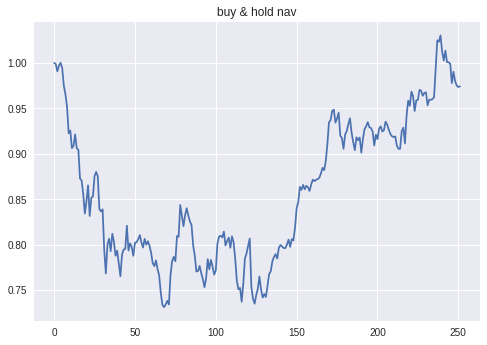

In [0]:
#import trading_env as te

stayflat     = lambda o,e: 1   # stand pat
buyandhold   = lambda o,e: 2   # buy on day #1 and hold
randomtrader = lambda o,e: e.action_space.sample() # retail trader

# to run singly, we call run_strat.  we are returned a dataframe containing 
#  all steps in the sim.
bhdf = env.run_strat(buyandhold)

print bhdf.head()

# we can easily plot our nav in time:
bhdf.bod_nav.plot(title='buy & hold nav')


### running the same strategy multiple times will likely yield different results as underlying data changes

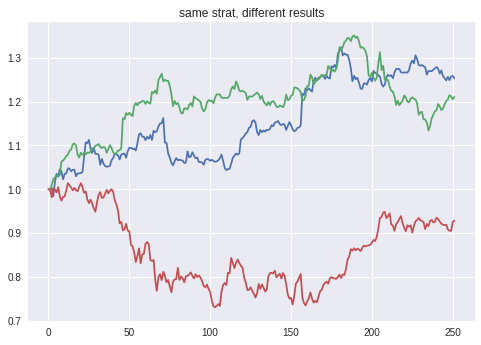

In [0]:
env.run_strat(buyandhold).bod_nav.plot(title='same strat, different results')
env.run_strat(buyandhold).bod_nav.plot()
env.run_strat(buyandhold).bod_nav.plot()

### comparing the buyandhold and random traders

In [0]:
# running a strategy multiple times should yield insights 
#   into its expected behavior or give it oppty to learn
bhdf = env.run_strats(buyandhold,100)
rdf = env.run_strats(randomtrader,100)

comparo = pd.DataFrame({'buyhold':bhdf.mean(),
                        'random': rdf.mean()})
comparo

INFO:__main__:writing log to /tmp/tmpV9qyfY
INFO:__main__:writing log to /tmp/tmpdgn4Hw


,buyhold,random
action,2.000000,0.997778
bod_nav,0.971602,0.883717
mkt_nav,0.985877,0.986844
mkt_return,-0.000106,-0.000089
sim_return,-0.000214,-0.001029
position,1.000000,-0.002222
costs,0.000104,0.000985
trade,0.003968,0.000000


## Object of the game

From the above examples, we can see that buying and holding will, over the long run, give you the market return with low costs.

Randomly trading will instead destroy value rather quickly as costs overwhelm.

### So, what does it mean to win the trading game?  

For our purposes, we'll say that beating a buy & hold strategy, on average, over one hundred episodes will notch a win to the proud ai player.

To support this, the trading environment maintains the *mkt_return* which can be compared with the *sim_return*.

Note that the *mkt_return* is frictionless while the *sim_return* incurs both trading costs and the decay cost of 1 basis point per day, so overcoming the hurdle we've set here should be challenging.


### Playing the game: purloined policy gradients

I've taken and adapted a policy gradient implementation based on tensorflow to try to play the single-instrument trading game.  Let's see how it does.

In [0]:
''' Policy Gradient implementation customized a bit for 
solving the trading problem'''
# stolen shamelessly and adapted December 2016 by Tito Ingargiola
# was originally:

'''Solution to the Cartpole problem using Policy Gradients in Tensorflow.'''
# written October 2016 by Sam Greydanus
# inspired by gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

import numpy as np
import gym
import tensorflow as tf
import pdb
import logging
import os.path
import pandas as pd
#import gym_trading

#import trading_env as te

logging.basicConfig()
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.info('%s logger started.',__name__)

class PolicyGradient(object) :
    """ Policy Gradient implementation in tensor flow.
   """
    
    def __init__(self,
                 sess,                # tensorflow session
                 obs_dim,             # observation shape
                 num_actions,         # number of possible actions
                 neurons_per_dim=32,  # hidden layer will have obs_dim * neurons_per_dim neurons
                 learning_rate=1e-2,  # learning rate
                 gamma = 0.9,         # reward discounting 
                 decay = 0.9          # gradient decay rate
                 ):
                 
        self._sess = sess
        self._gamma = gamma
        self._tf_model = {}
        self._num_actions = num_actions
        hidden_neurons = obs_dim * neurons_per_dim
        with tf.variable_scope('layer_one',reuse=False):
            L1 = tf.truncated_normal_initializer(mean=0,
                                                 stddev=1./np.sqrt(obs_dim),
                                                 dtype=tf.float32)
            self._tf_model['W1'] = tf.get_variable("W1",
                                                   [obs_dim, hidden_neurons],
                                                   initializer=L1)
        with tf.variable_scope('layer_two',reuse=False):
            L2 = tf.truncated_normal_initializer(mean=0,
                                                 stddev=1./np.sqrt(hidden_neurons),
                                                 dtype=tf.float32)
            self._tf_model['W2'] = tf.get_variable("W2",
                                                   [hidden_neurons,num_actions],
                                                   initializer=L2)
       
        # tf placeholders
        self._tf_x = tf.placeholder(dtype=tf.float32, shape=[None, obs_dim],name="tf_x")
        self._tf_y = tf.placeholder(dtype=tf.float32, shape=[None, num_actions],name="tf_y")
        self._tf_epr = tf.placeholder(dtype=tf.float32, shape=[None,1], name="tf_epr")

        # tf reward processing (need tf_discounted_epr for policy gradient wizardry)
        self._tf_discounted_epr = self.tf_discount_rewards(self._tf_epr)
        self._tf_mean, self._tf_variance= tf.nn.moments(self._tf_discounted_epr, [0], 
                                                        shift=None, name="reward_moments")
        self._tf_discounted_epr -= self._tf_mean
        self._tf_discounted_epr /= tf.sqrt(self._tf_variance + 1e-6)

        self._saver = tf.train.Saver()

        # tf optimizer op
        self._tf_aprob = self.tf_policy_forward(self._tf_x)
        loss = tf.nn.l2_loss(self._tf_y - self._tf_aprob) # this gradient encourages the actions taken
        optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=decay)
        tf_grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), 
                                               grad_loss=self._tf_discounted_epr)
        self._train_op = optimizer.apply_gradients(tf_grads)
    
    def tf_discount_rewards(self, tf_r): #tf_r ~ [game_steps,1]
        discount_f = lambda a, v: a*self._gamma + v;
        tf_r_reverse = tf.scan(discount_f, tf.reverse(tf_r,[True, False]))
        tf_discounted_r = tf.reverse(tf_r_reverse,[True, False])
        return tf_discounted_r

    def tf_policy_forward(self, x): #x ~ [1,D]
        h = tf.matmul(x, self._tf_model['W1'])
        h = tf.nn.relu(h)
        logp = tf.matmul(h, self._tf_model['W2'])
        p = tf.nn.softmax(logp)
        return p

    def train_model(self, env, episodes=100, 
                    load_model = False,  # load model from checkpoint if available:?
                    model_dir = '/tmp/pgmodel/', log_freq=10 ) :

        # initialize variables and load model
        init_op = tf.global_variables_initializer()
        self._sess.run(init_op)
        if load_model:
            ckpt = tf.train.get_checkpoint_state(model_dir)
            print tf.train.latest_checkpoint(model_dir)
            if ckpt and ckpt.model_checkpoint_path:
                savr = tf.train.import_meta_graph(ckpt.model_checkpoint_path+'.meta')
                out = savr.restore(self._sess, ckpt.model_checkpoint_path)
                print("Model restored from ",ckpt.model_checkpoint_path)
            else:
                print('No checkpoint found at: ',model_dir)
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

        episode = 0
        observation = env.reset()
        xs,rs,ys = [],[],[]    # environment info
        running_reward = 0    
        reward_sum = 0
        # training loop
        day = 0
        simrors = np.zeros(episodes)
        mktrors = np.zeros(episodes)
        alldf = None
        victory = False
        while episode < episodes and not victory:
            # stochastically sample a policy from the network
            x = observation
            feed = {self._tf_x: np.reshape(x, (1,-1))}
            aprob = self._sess.run(self._tf_aprob,feed)
            aprob = aprob[0,:] # we live in a batched world :/

            action = np.random.choice(self._num_actions, p=aprob)
            label = np.zeros_like(aprob) ; label[action] = 1 # make a training 'label'

            # step the environment and get new measurements
            observation, reward, done, info = env.step(action)
            #print observation, reward, done, info
            reward_sum += reward

            # record game history
            xs.append(x)
            ys.append(label)
            rs.append(reward)
            day += 1
            if done:
                running_reward = running_reward * 0.99 + reward_sum * 0.01
                epx = np.vstack(xs)
                epr = np.vstack(rs)
                epy = np.vstack(ys)
                xs,rs,ys = [],[],[] # reset game history
                df = env.sim.to_df()
                #pdb.set_trace()
                simrors[episode]=df.bod_nav.values[-1]-1 # compound returns
                mktrors[episode]=df.mkt_nav.values[-1]-1

                alldf = df if alldf is None else pd.concat([alldf,df], axis=0)
                
                feed = {self._tf_x: epx, self._tf_epr: epr, self._tf_y: epy}
                _ = self._sess.run(self._train_op,feed) # parameter update

                if episode % log_freq == 0:
                    log.info('year #%6d, mean reward: %8.4f, sim ret: %8.4f, mkt ret: %8.4f, net: %8.4f', episode,
                             running_reward, simrors[episode],mktrors[episode], simrors[episode]-mktrors[episode])
                    save_path = self._saver.save(self._sess, model_dir+'model.ckpt',
                                                 global_step=episode+1)
                    if episode > 100:
                        vict = pd.DataFrame( { 'sim': simrors[episode-100:episode],
                                               'mkt': mktrors[episode-100:episode] } )
                        vict['net'] = vict.sim - vict.mkt
                        if vict.net.mean() > 0.0:
                            victory = True
                            log.info('Congratulations, Warren Buffet!  You won the trading game.')
                    #print("Model saved in file: {}".format(save_path))

                
                    
                episode += 1
                observation = env.reset()
                reward_sum = 0
                day = 0
                
        return alldf, pd.DataFrame({'simror':simrors,'mktror':mktrors})


INFO:__main__:__main__ logger started.


In [0]:
import tensorflow as tf
#from gym_trading.envs.policy_gradient import PolicyGradient

In [0]:
# create the tf session
tf.reset_default_graph() 
sess1 = tf.InteractiveSession()
# create policygradient
pg = PolicyGradient(sess1, obs_dim=5, num_actions=3, learning_rate=1e-2 )

# and now let's train it and evaluate its progress.  NB: this could take some time...
df,sf = pg.train_model( env,episodes=25001, log_freq=100)#, load_model=True)


INFO:__main__:year #     0, mean reward:  -0.0027, sim ret:  -0.2423, mkt ret:  -0.1272, net:  -0.1151
INFO:__main__:year #   100, mean reward:  -0.0321, sim ret:  -0.0970, mkt ret:   0.0265, net:  -0.1235
INFO:__main__:year #   200, mean reward:  -0.0399, sim ret:  -0.0248, mkt ret:   0.2808, net:  -0.3056
INFO:__main__:year #   300, mean reward:  -0.0075, sim ret:  -0.0248, mkt ret:   0.1306, net:  -0.1554
INFO:__main__:year #   400, mean reward:   0.0458, sim ret:   0.3924, mkt ret:  -0.3327, net:   0.7251
INFO:__main__:Congratulations, Warren Buffet!  You won the trading game.


### Results

Policy gradients beat the trading game!  That said, it doesn't work every time and it seems, looking at the charts below, as though it's a bit of a lucky thing.  But luck counts in the trading game as in life!


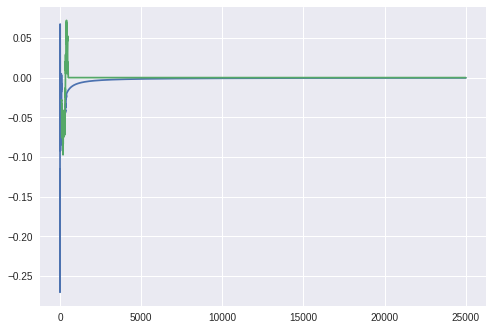

In [0]:
sf['net'] = sf.simror - sf.mktror
#sf.net.plot()
sf.net.expanding().mean().plot()
sf.net.rolling(100).mean().plot()

In [0]:
sf.net.rolling(100).mean().tail()

24996    0.0
24997    0.0
24998    0.0
24999    0.0
25000    0.0
Name: net, dtype: float64